In [1]:

from deepchem.feat import MolGraphConvFeaturizer
from rdkit import Chem
from sklearn.metrics import roc_auc_score
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from utils.SmilesEnumeration import SmilesEnumerator
import deepchem as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\predator\anaconda3\envs\dili\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


In [2]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Preprocessing DeepChem's MolGraphConvFeaturizer

In [3]:
# Featurization using DeepChem
featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)

# Function to convert SMILES to PyTorch Geometric Data object using DeepChem featurizer
def smiles_to_graph_featurizer(smiles, label):
    # Featurize the SMILES string using DeepChem
    graph_data = featurizer.featurize([smiles])[0]
    
    # Convert DeepChem's GraphData object to PyTorch Geometric Data
    x = torch.tensor(graph_data.node_features, dtype=torch.float)
    edge_index = torch.tensor(graph_data.edge_index, dtype=torch.long)
    edge_attr = torch.tensor(graph_data.edge_features, dtype=torch.float)
    y = torch.tensor([label], dtype=torch.long)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)


# Function to load data from CSV and apply SMILES augmentation using DeepChem's SmilesEnumerator
def load_data_from_csv(file_path, augment=False, augment_times=1):
    df = pd.read_csv(file_path)
    smiles_list = df['Smiles'].values
    labels = df['Liver'].apply(lambda x: 1 if x == 'Hepatotoxicity' else 0).values
    
    data_list = []
    
    # Initialize the SmilesEnumerator for data augmentation
    sme = SmilesEnumerator()
    
    for smiles, label in zip(smiles_list, labels):
        if augment:
            # Apply SMILES randomization (augmentation) for training data
            for _ in range(augment_times):
                augmented_smiles = sme.randomize_smiles(smiles)
                graph_data = smiles_to_graph_featurizer(augmented_smiles, label)
                data_list.append(graph_data)
        else:
            # For test data, no augmentation, just use canonical SMILES
            graph_data = smiles_to_graph_featurizer(smiles, label)
            data_list.append(graph_data)
    
    return data_list

In [4]:
# Load training and testing data
training_data = load_data_from_csv("data_smiles/Training_Group.csv", augment=True, augment_times=5)
testing_data = load_data_from_csv("data_smiles/Testing_Group.csv", augment=False)

# Create data loaders
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=32, shuffle=False)


c:\Users\predator\anaconda3\envs\dili\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [9]:
# for data in train_loader:
#     print(data)
#     break

In [5]:
# Training function with AUC and accuracy tracking
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    y_true = []
    y_pred = []

    for data in data_loader:
        data = data.to(device)  # Move data to GPU or CPU based on device
        optimizer.zero_grad()
        out = model(data)  # Forward pass
        loss = criterion(out, data.y)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Track metrics
        total_loss += loss.item()
        pred = out.argmax(dim=1)  # Get predicted class
        correct += (pred == data.y).sum().item()  # Count correct predictions
        y_true.extend(data.y.cpu().tolist())  # Move true labels back to CPU for metrics
        y_pred.extend(out[:, 1].detach().cpu().numpy())  # Probability for class 1

    acc = correct / len(data_loader.dataset)
    auc = roc_auc_score(y_true, y_pred)

    return total_loss / len(data_loader), acc, auc

In [6]:
# Testing/Validation function with AUC and accuracy tracking
def test(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    y_true = []
    y_pred = []

    with torch.no_grad():  # Disable gradient calculation for inference
        for data in data_loader:
            data = data.to(device)  # Move data to GPU or CPU based on device
            out = model(data)  # Forward pass
            loss = criterion(out, data.y)  # Compute loss

            # Track metrics
            total_loss += loss.item()
            pred = out.argmax(dim=1)  # Get predicted class
            correct += (pred == data.y).sum().item()  # Count correct predictions
            y_true.extend(data.y.cpu().tolist())  # Move true labels back to CPU for metrics
            y_pred.extend(out[:, 1].detach().cpu().numpy())  # Probability for class 1

    acc = correct / len(data_loader.dataset)
    auc = roc_auc_score(y_true, y_pred)

    return total_loss / len(data_loader), acc, auc

# GCN approach

## 2. Define GCN Model

In [7]:
# Define GCN Model
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # GCN layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Global mean pooling (per graph)
        x = global_mean_pool(x, data.batch)

        # Final classification layer
        out = self.fc(x)
        return out

## 3. Training Loop with Early Stopping and Metric Tracking

In [8]:
# Initialize the model, optimizer, and loss function
model = GCN(num_node_features=30, hidden_channels=32, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

best_auc = 0
early_stop_counter = 0
max_epochs = 1000  # Max epochs
patience = 200  # Early stopping patience

# Metrics storage for plotting
train_acc_history, train_loss_history, train_auc_history = [], [], []
test_acc_history, test_loss_history, test_auc_history = [], [], []

for epoch in range(max_epochs):
    train_loss, train_acc, train_auc = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc, test_auc = test(model, test_loader, criterion)

    # Store metrics for plotting
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
    train_auc_history.append(train_auc)
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss)
    test_auc_history.append(test_auc)

    print(f"Epoch {epoch+1}:")
    print(
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}"
    )
    print(
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}"
    )

    # Early stopping
    if test_auc > best_auc:
        best_auc = test_auc
        early_stop_counter = 0  # Reset counter if improvement
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1:
Train Loss: 0.6643, Train Acc: 0.6035, Train AUC: 0.6271
Test Loss: 0.6203, Test Acc: 0.6643, Test AUC: 0.7894
Epoch 2:
Train Loss: 0.6441, Train Acc: 0.6301, Train AUC: 0.6691
Test Loss: 0.5195, Test Acc: 0.7448, Test AUC: 0.7857
Epoch 3:
Train Loss: 0.6251, Train Acc: 0.6403, Train AUC: 0.6956
Test Loss: 0.6018, Test Acc: 0.6783, Test AUC: 0.7908
Epoch 4:
Train Loss: 0.6112, Train Acc: 0.6608, Train AUC: 0.7163
Test Loss: 0.6095, Test Acc: 0.6678, Test AUC: 0.7637
Epoch 5:
Train Loss: 0.6083, Train Acc: 0.6670, Train AUC: 0.7191
Test Loss: 0.6007, Test Acc: 0.6643, Test AUC: 0.7163
Epoch 6:
Train Loss: 0.5952, Train Acc: 0.6772, Train AUC: 0.7375
Test Loss: 0.5686, Test Acc: 0.7203, Test AUC: 0.7409
Epoch 7:
Train Loss: 0.5905, Train Acc: 0.6835, Train AUC: 0.7422
Test Loss: 0.5306, Test Acc: 0.7308, Test AUC: 0.7432
Epoch 8:
Train Loss: 0.5838, Train Acc: 0.6875, Train AUC: 0.7510
Test Loss: 0.6168, Test Acc: 0.6224, Test AUC: 0.7243
Epoch 9:
Train Loss: 0.5774, Train Acc: 

## 4. Evaluation function

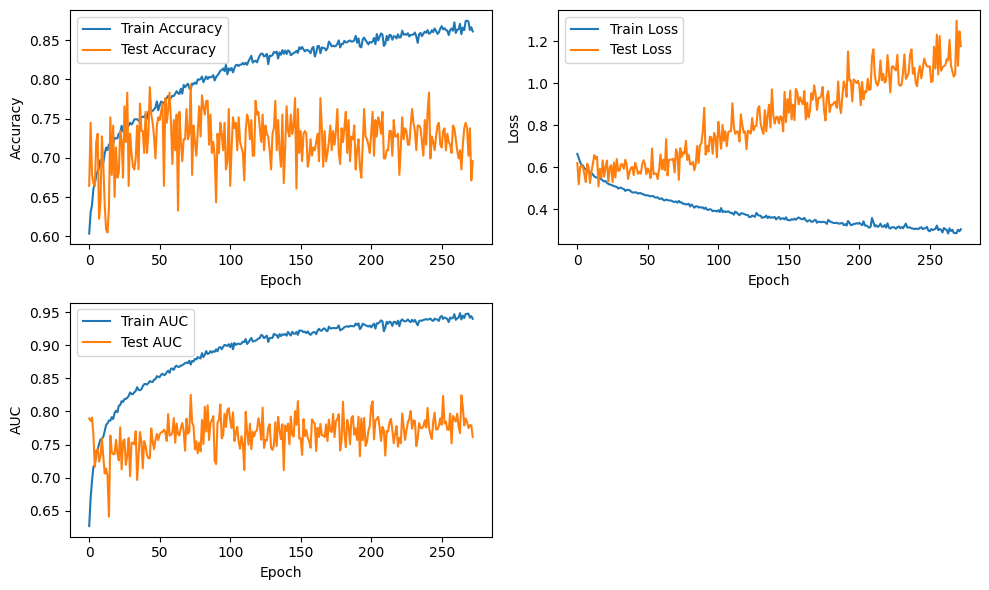

In [9]:
# Plot training and testing accuracy
epochs = len(train_acc_history)
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(range(epochs), train_acc_history, label="Train Accuracy")
plt.plot(range(epochs), test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(epochs), train_loss_history, label="Train Loss")
plt.plot(range(epochs), test_loss_history, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot AUC for train and test
plt.subplot(2, 2, 3)
plt.plot(range(epochs), train_auc_history, label="Train AUC")
plt.plot(range(epochs), test_auc_history, label="Test AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()